## One: ER Diagram

In this task, I intend to prodive a structured data warehouse based on the provided unstructured json files. The image below shows an ER diagram representing a database schema with three interconnected tables: users, receipts, and brands.


- The users table has the primary key _id, which is the unique ID for each user, and includes various user attributes.

- The receipts table has the primary key _id, which is the unique ID for each receipt, and contains various attributes about the receipts. Foreign keys barcode (which is one of the fields under rewardsReceiptItemList json) and userId reference the brands and users tables respectively.

- The brands table has _id which is unique for each brand, and includes attributes about different brands.


The relationships are indicated by lines connecting the primary and foreign keys, showing how the tables relate to each other: userId in receipts references _id in users, and barcode in receipts references barcode in brands. There is one-to-many from _id in users to userId in receipts, and one-to-many from barcode in brands to barcode in receipts. This setup allows the database to link receipts to specific users and brands.

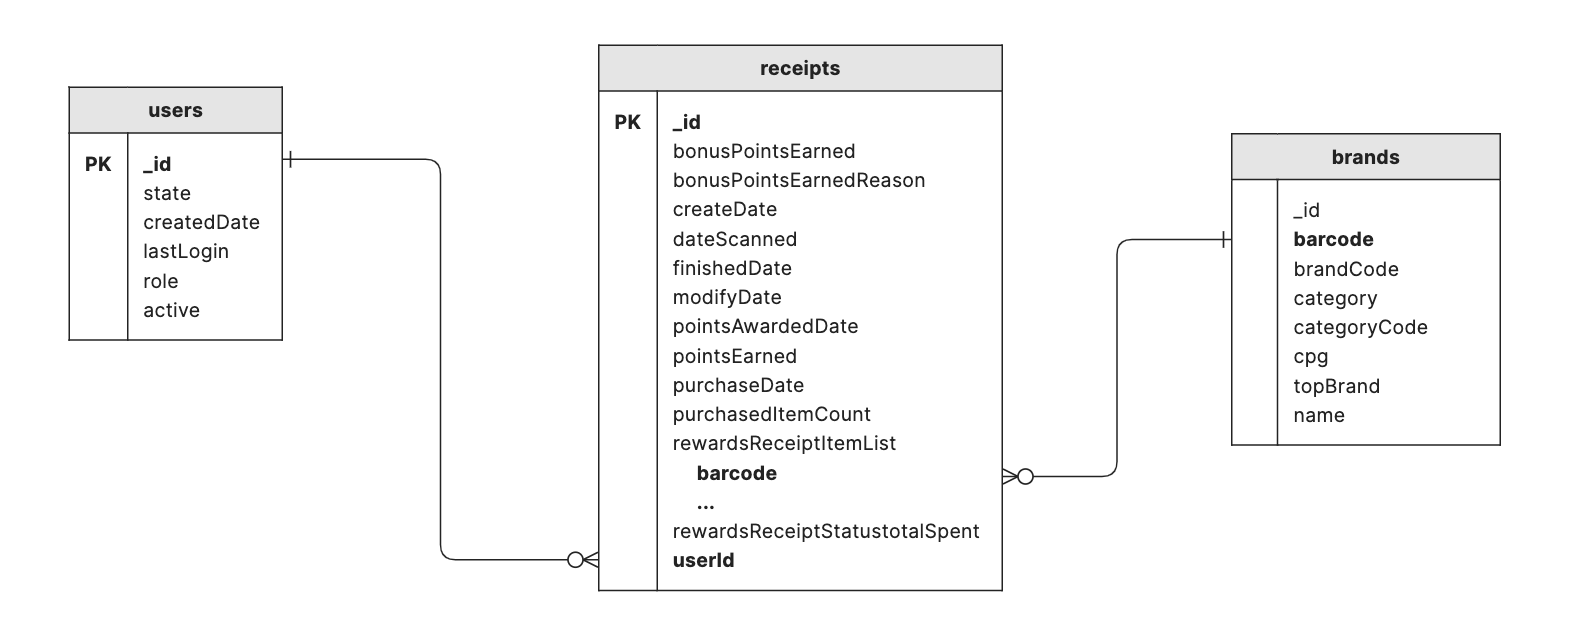

In [1]:
from IPython.display import Image
Image("../data/ER diagram.png")

## Two: SQL Queries

The SQL queries below will answer the five interesting business questions correspondingly. (Note: queries below are in SparkSQL language)
### a. Top brands by number of receipts scanned
Results from the below SQL query will show the following:
- Given any date, What are the top 5 brands by receipts scanned for the past 30 days?
- How does the ranking of the top 5 brands compare to the ranking for the previous 30 days? (Positive numbers indicate number of ranks increase. For example, a brand ranked up from 3 to 1 will have a rank_increase of 2.)

In [ ]:
with this_month as (
    select
        b.name as brand_name,
        row_number() over (order by count(r.id) desc) as brand_rk
    from receipts r
    inner join brands b
        on get_json_object(r.rewardsReceiptItemList, '$.barcode') = b.barcode
    where dateScanned between '${date-29}' and '${date}'
    group by b.name
),

prev_month as (
    select
        b.name as brand_name,
        row_number() over (order by count(r.id) desc) as brand_rk
    from receipts r
    inner join brands b
        on get_json_object(r.rewardsReceiptItemList, '$.barcode') = b.barcode
    where dateScanned between '${date-59}' and '${date-30}'
    group by b.name
)

select
    t.brand_rk,
    t.brand_name,
    t.brand_rk - p.brand_rk as rank_increase
from this_month t
left join prev_month p
    on t.brand_name = p.brand_name
where t.brand_rk <= 5 -- can change to any number

### b. Comparison of spending and item count between receipt status
Results from the below SQL query will show the following:
- When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?
- When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [ ]:
select
    rewardsReceiptStatus,
    avg(totalSpent) as avg_spend,
    sum(purchasedItemCount) as total_items
from receipts
group by rewardsReceiptStatus

### c. Top brands for new users
Results from the below SQL query will show one of the following:
- Which brand has the most spend among users who were created within the past 6 months?
- Which brand has the most transactions (number of receipts) among users who were created within the past 6 months?

In [ ]:
with calc as (
    select
        b.name as brand_name,
        sum(r.totalSpent) as total_spent,
        count(r.id) as total_transaction,
        row_number() over (order by sum(r.totalSpent) desc) as spent_rk,
        row_number() over (order by count(r.id) desc) as transaction_rk
    from receipts r
    inner join users u
        on r.userId = u.id
        and u.createdDate between '${date-180}' and '${date}'
    inner join brands b
        on get_json_object(r.rewardsReceiptItemList, '$.barcode') = b.barcode
    group by b.name
)

select
    brand_name
from calc
where
--uncomment one line from below to get the top 1 brand name for either total spent or number of transactions
    --spent_rk = 1
    --transaction_rk = 1

## Three: Data Quality Issues

The following data quality issues were identified. This is not a complete list, and deeper investigation and further discussion are required to fully address all data quality issues. For the code to investigate the three data sets, please refer to 'Data Quality Check.ipynb' under 'supporting files' folder.

1. Missing Values

Multiple fields have missing values. We have to be careful when interpreting missing values. 

For fields such as bonusPointsEarned and finishedDate, it is reasonable to assume that missing values can be treated as NULL, as their absence likely indicates that the relevant data was not applicable or was not captured at the time of entry. In analyses where these fields are critical, such as calculating total bonus points, null values can be safely ignored without significantly affecting the results.

However, for fields including purchaseDate, purchasedItemCount, and totalSpent, the presence of missing values is more concerning and likely indicative of data extraction issues from receipts. When conducting analyses involving these fields, it is essential to address these missing values with caution. Assumptions of null values in these cases may lead to inaccurate conclusions, necessitating a more thorough data quality assessment and possibly imputation or exclusion strategies to ensure analytical integrity. Even more, the amount of NULLs for these fields are concerning: about 40% of each field is NULL.

2. Incorrect Data Types

The totalSpent column in receipts is of type object instead of a numeric type (e.g., float64). We should change it to numeric to perform analysis based on spend by brand, user, etc

3. Potential Outliers

The max of purchasedItemCount column in receipts is 689, which might indicate potential outliers or errors in the data.

4. Duplicate Values

id in users table is not unique. In fact over 50% of user IDs are duplicated. This is very concerning since we want to set user ID as the primary key for this table and having duplicates will mess up our user behavior analysis when we join this table with receipts.

## Four: An Email for a Product or Business Leader

### Subject: Improving Data Quality Across Receipts, Users, and Brands Datasets

Dear xxx,

I hope this message finds you well. I am writing to address some important observations and questions regarding the quality of our Receipts, Users, and Brands datasets. Improving these areas is crucial for enhancing our data assets and ensuring accurate insights for business decisions.

#### Data Quality Issues and Questions

During my analysis, several key issues regarding data quality have come to light and I wanted to clarify on:
- Data Completeness: Fields essential for analysis, such as date of purchase and spend amount in the Receipts dataset, often lack data entries, likely affecting our reporting accuracy. Could we pinpoint the reasons behind these gaps to improve data completeness?
- Data Duplication: Could you provide insights into why we have duplicate entries in the Users dataset? Addressing these duplicates would streamline our data operations.

#### Information Needed for Resolution

To effectively resolve these issues, I would appreciate clarity on:
- Data Integration: Understanding our current pipelines for data cleaning and integration will help mitigate inconsistencies and improve data reliability.
- Validation Processes: Insights into our existing validation rules will aid in establishing robust strategies for handling and verifying data integrity.

#### Further Insights for Optimizing Data Assets

To optimize our data for enhanced business use, I believe the following information would be beneficial:
- Use Case Scenarios: Understanding how different departments utilize this data will help prioritize improvements that directly impact business outcomes.
- User Feedback: Feedback from stakeholders using these datasets can reveal specific pain points and opportunities for usability improvements.

#### Anticipated Performance and Scaling Concerns

As we move towards implementation, I foresee several performance and scaling considerations and therefore propose the following approach:
- Scalable Infrastructure: Scaling our data processing capabilities to accommodate growing volumes efficiently is critical. We should transition to cloud-based solutions, which will provide the scalability needed to handle increased data volumes while optimizing resource allocation.
- Data Integrity Assurance: Maintaining data consistency throughout processing stages is also important. We should implement robust monitoring tools, which will enable proactive identification and resolution of data quality issues, ensuring continuous data reliability.

 
 
I look forward to discussing these strategies further to devise a comprehensive plan that aligns with our business objectives. Your insights and guidance in this endeavor are invaluable.

Thank you for your attention to these matters.

Best regards,

Yifei D